In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pfjax as pf
from pfjax import particle_resamplers as resampler
import pfjax.sde as sde
import pfjax.mcmc as mcmc

import numpy as np

In [2]:
class AdaptiveMetropolis:
    r"""
    Adaptive Metropolis in Roberts and Rosenthal (2009).

    Args:
        mix_par: Scalar of mixing parameter in the Gaussian mixture model.
        adapt_rate: Scalar of covariance inflation parameter.

    .. _BlackJAX: https://blackjax-devs.github.io/blackjax/index.html
    .. |BlackJAX| replace:: **BlackJAX**
    """

    def __init__(self, max_iter=100, mix_par=0.05, infl_par=2.38):
        self._max_iter = max_iter
        self._mix_par = mix_par
        self._infl_par = infl_par
        
    def adapt(self, pars, position_new):
        r"""
        Update empirical covariance matrix.

        Args:
            pars: Adaptation parameters.  A dictionary with elements:

                - `XTX`: Array of transpose product of parameter draws.
                - `EX`: Empirical average of parameter draws.
                - `cov_prop`: Current proposal covariance matrix.
                - `n_iter`: Number of AM iterations (cycles) so far.
                - `n_accept`:The number of accepted draws so far.
            
            position_new: New draw of parameters.
            accept: Boolean vector indicating whether or not the latest proposal was accepted.

        Returns:
            Dictionary:
            
            - **n_iter** - Updated number of iterations, i.e., ``n_iter += 1``.
            - **n_accept** - Updated number of accepted draws, i.e., ``n_accept += accept``.
        """
        n_iter = pars["n_iter"] + 1.
        
        # Updating necessary terms to compute empirical covariance
        XTX = (pars["XTX"] * (n_iter-1) + jnp.outer(position_new, position_new)) / n_iter
        EX = (pars["EX"] * (n_iter-1) + position_new) / n_iter
        
        # Empirical covariance structure of parameters
        Sigma = XTX - jnp.outer(EX, EX) / n_iter
        cov1 = pars["cov_pars"]["cov1"]
        cov2 = lax.cond(n_iter>self._max_iter,
                        lambda: self._infl_par**2 * Sigma, # inflated covariance
                        lambda: cov1)
        
        return {
            "cov_pars": {
                "cov1": cov1,
                "cov2": cov2,
                "mix_par": self._mix_par
            },
            "XTX": XTX,
            "EX": EX,
            "n_iter": n_iter
        }
    
    def init(self, cov1):
        r"""
        Initialize the adaptation parameters.

        Args:
            rw_sd: A vector of initial standard deviations for the componentwise random walk proposal.

        Returns: 

            Dictionary:

            - **rw_sd** - The vector of  standard deviations for the componentwise random walk proposal.
            - **n_iter** - The number of MWG steps taken so far, which is zero.
            - **n_accept** - The number of draws accepted so far, which is zero.
        """
        d = cov1.shape[0]
        return {
            "cov_pars": {
                "cov1": cov1,
                "cov2": cov1,
                "mix_par": self._mix_par
            },
            "XTX": jnp.zeros((d,d)),
            "EX": jnp.zeros(d),
            "n_iter": 0
        }

    def step(self, key, position_curr, lp_curr, logprob_fn, mix_par, cov1, cov2):
        r"""
        Update parameters via adaptive Metropolis-within-Gibbs.

        Args:
            key: PRNG key.
            position: The current position of the sampler.
            logprob_fn: Function which takes a JAX array input `position` and returns a scalar corresponding to the log of the probability density at that input.
            
        Returns: 

            Tuple:

            - **position** - The updated position.
            - **accept** - Scalar indicating whether or not proposal was accepted.
        """
        
        # 3 subkeys for each position: mixture draw, parameter draw and MH accept
        key, *subkeys = random.split(key, num=5)
        draw = random.bernoulli(subkeys[0], p=mix_par)
        d = len(position_curr)
        
        # covariance matrix        
        cov = cov1 * draw + cov2 * (1-draw)
        
        # proposal
        position_prop = random.multivariate_normal(key=subkeys[1],
                                                   mean=position_curr,
                                                   cov=cov)
        # acceptance rate
        lp_prop = logprob_fn(position_prop, subkeys[2])
        lrate = lp_prop - lp_curr
        # update parameter draw
        acc = random.bernoulli(key=subkeys[3],
                               p=jnp.minimum(1.0, jnp.exp(lrate)))
        position = position_prop * acc + position_curr * (1-acc)
        lp = lp_prop * acc + lp_curr * (1-acc)
        
        return position, acc, lp


In [3]:
def adaptive_metropolis(key, model, am, y_meas, n_iter, theta_init, x_state_init, n_particles, logprior, cov1):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    key, subkey = random.split(key)
    # initialize the sampler
    n_params = theta_init.size
    
    def logpost(theta, key):
        """
        Log-posterior of the conditional parameter distribution.
        """
        pf_out = pf.particle_filter(
            model=model,
            key=key,
            y_meas=y_meas,
            theta=theta,
            n_particles=n_particles,
            history=False
        )

        return pf_out["loglik"] + logprior(theta)

    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": am.init(cov1),
        "lp": logpost(theta_init, subkey)
    }
    
    def mcmc_update(key, theta, x_state, adapt_pars, lp):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        # latent variable update
        
        """
        # parameter update
        def logpost(theta):
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            ) + logprior(theta)
        
        """
        
        theta_state, accept, lp = am.step(
            key=key, 
            position_curr=theta, 
            lp_curr=lp, 
            logprob_fn=logpost, 
            mix_par=am._mix_par, 
            cov1=adapt_pars["cov_pars"]["cov1"], 
            cov2=adapt_pars["cov_pars"]["cov2"]
        )
        
        # adapt random walk jump sizes
        adapt_pars = am.adapt(adapt_pars, theta_state) 
        
        return theta_state, x_state, adapt_pars, accept, lp

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept, lp = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"],
            lp=state["lp"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars,
            "lp":lp
            
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    return out

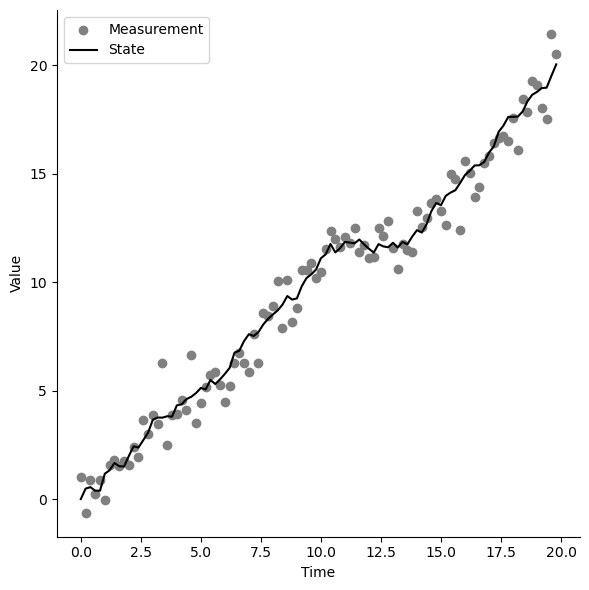

In [4]:
from pfjax.models import BMModel
# initial key for random numbers
key = random.PRNGKey(0)

# parameter values
mu, sigma, tau = 1., .5, .8
theta_true = jnp.array([mu, jnp.log(sigma), jnp.log(tau)])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = BMModel(
    dt=dt, 
    unconstrained_theta=True # puts theta on the unconstrained scale
) 
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas)}))

g = sns.FacetGrid(plot_df, height = 6)
g = g.map(plt.scatter, "time", "meas", color="grey")
plt.plot(plot_df['time'], plot_df['state'], color='black')
plt.legend(labels=["Measurement","State"])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [5]:
n_particles = 100
rw_sd = 0.01 * jnp.array([1., 1., 1.])
n_iter = 10_000

am = AdaptiveMetropolis(max_iter=50, mix_par=0.05, infl_par=2.38)

key, subkey = jax.random.split(key)

import time

t = time.process_time()
am_out = adaptive_metropolis(
    key=subkey, 
    model=bm_model, 
    am=am,
    y_meas=y_meas, 
    n_iter=n_iter, 
    theta_init=theta_true, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    logprior=lambda x: 0., 
    cov1=jnp.diag(rw_sd)
)
elapsed_time = time.process_time() - t

In [6]:
elapsed_time

11.272826

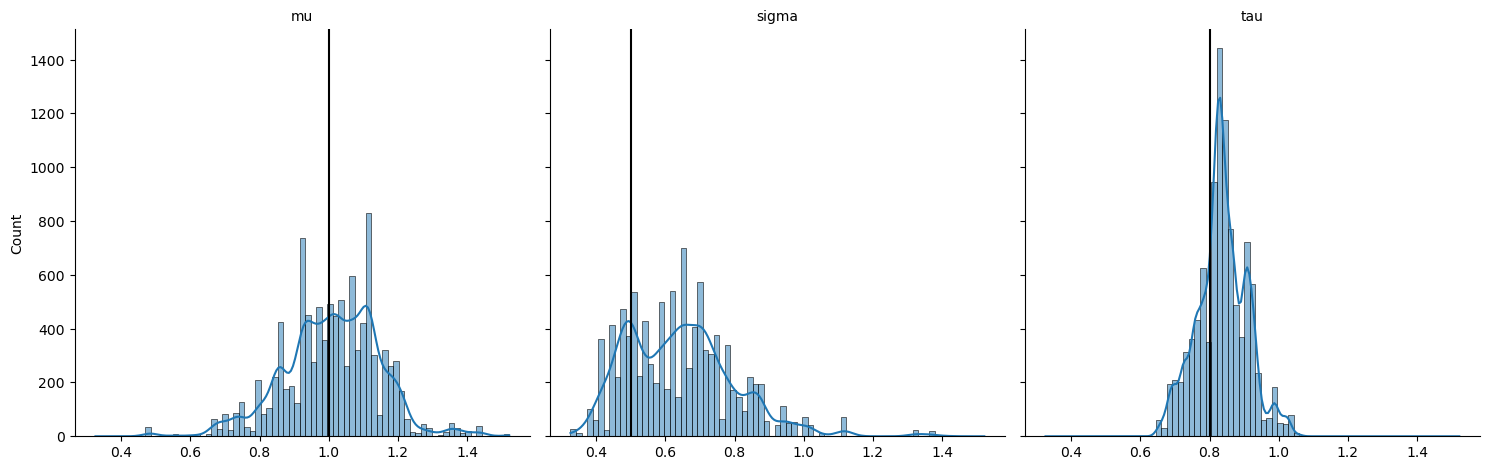

In [7]:
plot_am = pd.DataFrame({"iter": jnp.arange(n_iter),
                         "mu": am_out['theta'][:,0],
                         "sigma": jnp.exp(am_out['theta'][:,1]),
                         "tau": jnp.exp(am_out['theta'][:,2])})
plot_am = pd.melt(plot_am, id_vars=['iter'], value_vars=['mu', 'sigma', 'tau'])

hp = sns.displot(
    data=plot_am, 
    x="value", 
    col="variable",
    kde=True)

hp.set_titles(col_template="{col_name}")
hp.set(xlabel=None)
# add true parameter values
for ax, theta, col in zip(hp.axes.flat, jnp.array([mu, sigma, tau]), ["mu","sigma","tau"]):
    #sns.displot(plot_imp[col], ax=ax)
    ax.axvline(theta, color="black")

plt.show()

In [8]:
def particle_gibbs(key, model, n_iter, theta_init, x_state_init, n_particles, rw_sd):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    # initialize the sampler
    n_params = theta_init.size
    amwg = mcmc.AdaptiveMWG(adapt_max=0.1, adapt_rate=0.01)
    # initial state of MWG sampler
    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": amwg.init(rw_sd),
    }

    def mcmc_update(key, theta, x_state, adapt_pars):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        keys = jax.random.split(key, num=3) # two for particle_filter, one for amwg
        # latent variable update
        pf_out = pf.particle_filter(
            model=model,
            key=keys[0],
            y_meas=y_meas,
            theta=theta,
            n_particles=n_particles,
            history=True
        )
        x_state = pf.particle_smooth(
            key=keys[1],
            logw=pf_out["logw"][y_meas.shape[0]-1],
            x_particles=pf_out["x_particles"],
            ancestors=pf_out["resample_out"]["ancestors"]
        )
        # parameter update
        def logpost(theta):
            """
            Log-posterior of the conditional parameter distribution.
            """
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            )
        theta_state, accept = amwg.step(
            key=keys[2],
            position=theta,
            logprob_fn=logpost,
            rw_sd=adapt_pars["rw_sd"]
        )
        # adapt random walk jump sizes
        adapt_pars = amwg.adapt(pars=adapt_pars, accept=accept)
        return theta_state, x_state, adapt_pars, accept

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    # calculate acceptance rate
    out["accept_rate"] = (1.0 * state["adapt_pars"]["n_accept"]) / n_iter
    return out

In [9]:
t = time.process_time()
pg_out = particle_gibbs(
    key=subkey, 
    model=bm_model, 
    n_iter=n_iter, 
    theta_init=theta_true, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    rw_sd=rw_sd
)
elapsed_time = time.process_time() - t

In [10]:
elapsed_time

8.034139

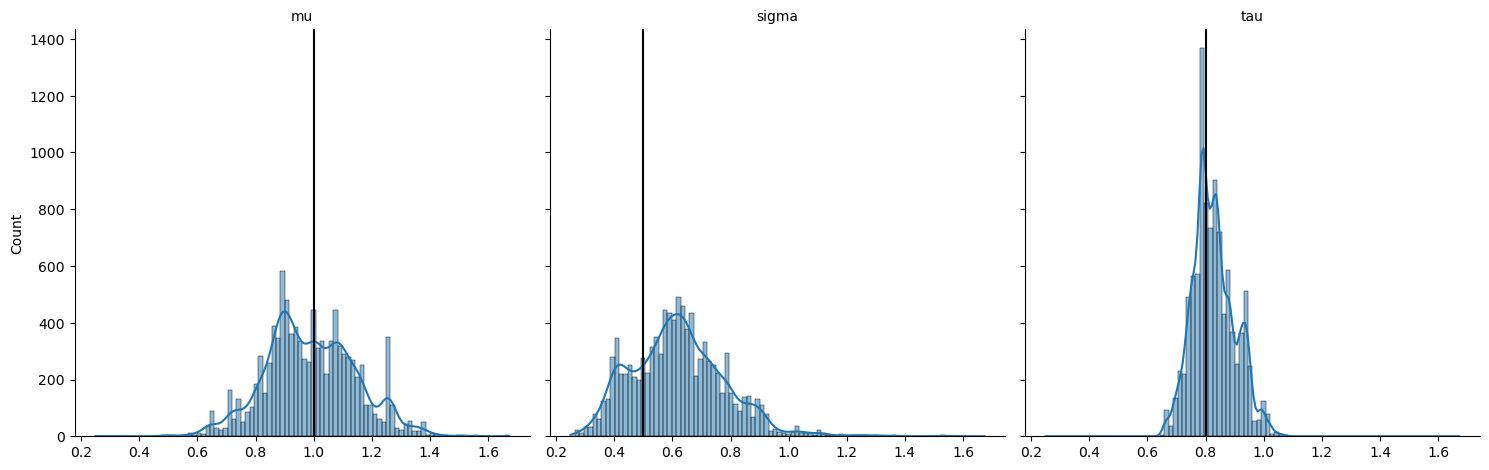

In [11]:
plot_pg = pd.DataFrame({"iter": jnp.arange(n_iter),
                         "mu": pg_out['theta'][:,0],
                         "sigma": jnp.exp(pg_out['theta'][:,1]),
                         "tau": jnp.exp(pg_out['theta'][:,2])})
plot_pg = pd.melt(plot_pg, id_vars=['iter'], value_vars=['mu', 'sigma', 'tau'])

hp = sns.displot(
    data=plot_pg, 
    x="value", 
    col="variable",
    kde=True)

hp.set_titles(col_template="{col_name}")
hp.set(xlabel=None)
# add true parameter values
for ax, theta, col in zip(hp.axes.flat, jnp.array([mu, sigma, tau]), ["mu","sigma","tau"]):
    #sns.displot(plot_imp[col], ax=ax)
    ax.axvline(theta, color="black")

plt.show()

In [ ]:
plt.plot(plot_pg['theta'])

In [12]:
grad_fun = jax.jit(jax.grad(bm_model.loglik_exact, argnums = 1))

# Gradient ascent learning rate
learning_rate = 0.01

theta_mode = theta_true

for i in range(1000):
    grads = grad_fun(y_meas, theta_mode)
    # Update parameters via gradient ascent
    theta_mode = theta_mode + learning_rate * grads

# def hessian(f):
#     return jax.jacfwd(jax.grad(f, argnums = 2), argnums = 2)

# hess = hessian(bm_loglik)(y_meas, dt, theta_mode)
hess = jax.jacfwd(jax.jacrev(bm_model.loglik_exact, argnums=1), argnums=1)(y_meas, theta_mode)
theta_quad = -jnp.linalg.inv(hess)

print(theta_mode)
print(theta_true)
print(theta_quad)

[ 0.99621826 -0.5639315  -0.18586011]
[ 1.         -0.6931472  -0.22314353]
[[ 0.01736945  0.00142614 -0.00024736]
 [ 0.00142613  0.05735585 -0.00402146]
 [-0.00024736 -0.0040215   0.00662397]]


In [13]:
# Draw from the mode-quadrature distribution
infl = 1.5  # Inflation factor
key, subkey = jax.random.split(key)
draws = random.multivariate_normal(
    subkey, mean=theta_mode, cov=infl*theta_quad, shape=(n_iter,))

logpost = jax.jit(bm_model.loglik_exact)

# Importance sampling with mode-quadrature proposal and target proposal (BM log-likelihood)
logq_x = jsp.stats.multivariate_normal.logpdf(
    draws, mean=theta_mode, cov=infl*theta_quad)
# logp_x = jnp.array([bm_loglik(y_meas, dt, draws[i,:]) for i in range(n_iter)])
logp_x = jax.vmap(
    fun=logpost,
    in_axes=(None, 0)
)(y_meas, draws)

# Get the likelihood ratio and normalize
logw = logp_x - logq_x
prob = pf.utils.logw_to_prob(logw)

# importance sample
key, subkey = jax.random.split(key)
imp_index = jax.random.choice(
    subkey, a=n_iter, p=prob, shape=(n_iter,), replace=True)
theta_imp = draws[imp_index, :]

In [52]:
plot_imp = pd.DataFrame({"iter": jnp.arange(n_iter),
                           "mu": theta_imp[:,0],
                           "sigma": jnp.exp(theta_imp[:,1]),
                           "tau": jnp.exp(theta_imp[:,2])})

plot_imp = pd.melt(plot_imp, id_vars=['iter'], value_vars=['mu', 'sigma', 'tau'])

plot_df = pd.concat([plot_pg, plot_am, plot_imp], ignore_index=True)
plot_df["Method"] = np.repeat(["APG", "AM", "IS"], len(plot_am["variable"]))


hp = sns.displot(
    data=plot_df, 
    x="value", 
    hue="Method",
    row="variable",
    kind="kde",
    fill=True,
    height=2,
    aspect=2,
    facet_kws={'sharey': False, 'sharex': True},
    alpha=0.1
)

hp.set_titles(col_template="{col_name}")
hp.set(xlabel=None)
# add true parameter values
for ax, theta in zip(hp.axes.flat, jnp.array([mu, sigma, tau])):
    ax.axvline(theta, color="black")

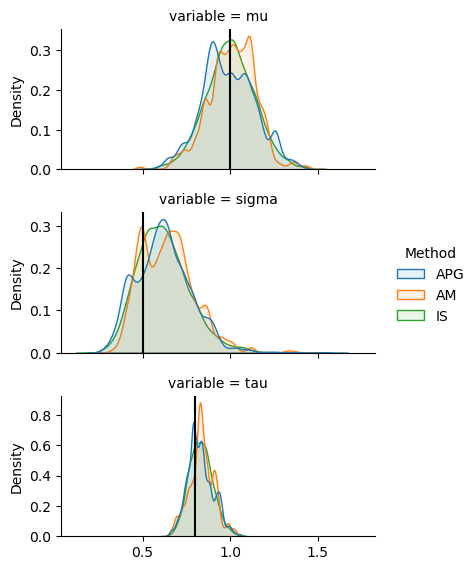

In [53]:
plt.show()

In [19]:
fig, ax = plt.subplots(3,1)

for i in range(3):
    d = 
    sns.distplot(data, bins = 25, ax = ax[i,0], norm_hist = False, hist = True, kde=False).set_title(feature)

plt.show()

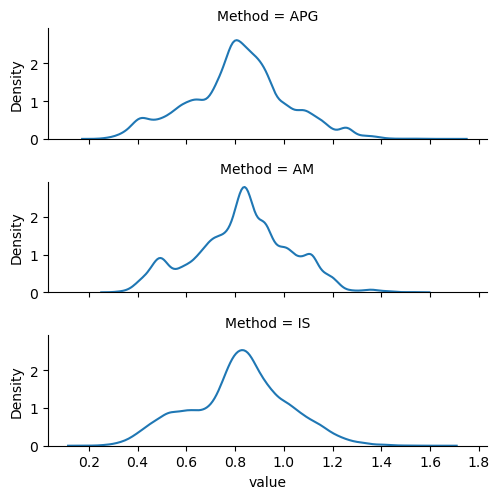

In [20]:
plt.show()